# NOVAS FEATURES

In [36]:
import pandas as pd
import numpy as np
import pickle
import sys
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import nltk
from nltk.stem.porter import *
import string
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline
%config IPCompleter.greedy=True

N_JOBS = 10

In [3]:
df = pd.read_csv("datasets/labeled_data.csv")

In [4]:
df.head()

Unnamed: 0  count  hate_speech  offensive_language  neither  class  \
0           0      3            0                   0        3      2   
1           1      3            0                   3        0      1   
2           2      3            0                   3        0      1   
3           3      3            0                   2        1      1   
4           4      6            0                   6        0      1   

                                               tweet  
0  !!! RT @mayasolovely: As a woman you shouldn't...  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...  
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...  
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...

In [5]:
df.describe()

Unnamed: 0         count   hate_speech  offensive_language  \
count  24783.000000  24783.000000  24783.000000        24783.000000   
mean   12681.192027      3.243473      0.280515            2.413711   
std     7299.553863      0.883060      0.631851            1.399459   
min        0.000000      3.000000      0.000000            0.000000   
25%     6372.500000      3.000000      0.000000            2.000000   
50%    12703.000000      3.000000      0.000000            3.000000   
75%    18995.500000      3.000000      0.000000            3.000000   
max    25296.000000      9.000000      7.000000            9.000000   

            neither         class  
count  24783.000000  24783.000000  
mean       0.549247      1.110277  
std        1.113299      0.462089  
min        0.000000      0.000000  
25%        0.000000      1.000000  
50%        0.000000      1.000000  
75%        0.000000      1.000000  
max        9.000000      2.000000

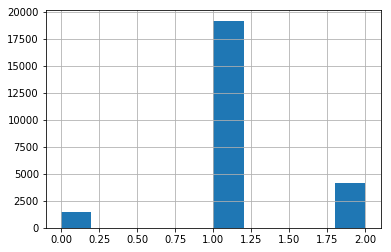

In [6]:
df['class'].hist()

In [7]:
tweets = df.tweet

## Feature generation

In [8]:
stopwords=stopwords = nltk.corpus.stopwords.words("english")

other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)

stemmer = PorterStemmer()


def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    return parsed_text

def tokenize(tweet):
    """Removes punctuation & excess whitespace, sets to lowercase,
    and stems tweets. Returns a list of stemmed tokens."""
    tweet = " ".join(re.split("[^a-zA-Z]+", tweet.lower())).strip()
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens

def basic_tokenize(tweet):
    """Same as tokenize but without the stemming"""
    tweet = " ".join(re.split("[^a-zA-Z.,!?]+", tweet.lower())).strip()
    return tweet.split()

vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    stop_words=stopwords,
    use_idf=True,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75
)

In [9]:
#Construct tfidf matrix and get relevant scores
tfidf = vectorizer.fit_transform(tweets).toarray()
vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names())}

In [10]:
#Get POS tags for tweets and save as a string
tweet_tags = []
for t in tweets:
    tokens = basic_tokenize(preprocess(t))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    tweet_tags.append(tag_str)

In [11]:
#We can use the TFIDF vectorizer to get a token matrix for the POS tags
pos_vectorizer = TfidfVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None,
    use_idf=False,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=5000,
    min_df=5,
    max_df=0.75,
)

In [12]:
#Construct POS TF matrix and get vocab dict
pos = pos_vectorizer.fit_transform(pd.Series(tweet_tags)).toarray()
pos_vocab = {v:i for i, v in enumerate(pos_vectorizer.get_feature_names())}

In [13]:
#Now get other features
sentiment_analyzer = VS()

def count_twitter_objs(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE
    4) hashtags with HASHTAGHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned.
    
    Returns counts of urls, mentions, and hashtags.
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    
    return (
        parsed_text.count('URLHERE'),
        parsed_text.count('MENTIONHERE'),
        parsed_text.count('HASHTAGHERE')
    )

def other_features(tweet):
    """This function takes a string and returns a list of features.
    These include Sentiment scores, Text and Readability scores,
    as well as Twitter specific features"""
    sentiment = sentiment_analyzer.polarity_scores(tweet)
    
    words = preprocess(tweet) #Get text only
    
    syllables = textstat.syllable_count(words)
    num_chars = sum(len(w) for w in words)
    num_chars_total = len(tweet)
    num_terms = len(tweet.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))
    
    ###Modified FK grade, where avg words per sentence is just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    twitter_objs = count_twitter_objs(tweet)
    retweet = 0
    
    if "rt" in words:
        retweet = 1
        
    features = [
        FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
        num_unique_terms, sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],
        twitter_objs[2], twitter_objs[1],
        twitter_objs[0], retweet
    ]
    
    return features

def get_feature_array(tweets):
    return np.array([other_features(t) for t in tweets])

In [14]:
other_features_names = [
    "FKRA", "FRE","num_syllables", "avg_syl_per_word", "num_chars", "num_chars_total",
    "num_terms", "num_words", "num_unique_words", "vader neg","vader pos","vader neu",
    "vader compound", "num_hashtags", "num_mentions", "num_urls", "is_retweet"
]

In [15]:
feats = get_feature_array(tweets)

In [16]:
feats.shape

(24783, 17)

In [17]:
#Now join them all up
M = np.concatenate([tfidf,pos,feats],axis=1)

In [18]:
#Finally get a list of variable names
variables = ['']*len(vocab)
for k,v in vocab.items():
    variables[v] = k

pos_variables = ['']*len(pos_vocab)
for k,v in pos_vocab.items():
    pos_variables[v] = k

feature_names = variables + pos_variables + other_features_names

In [19]:
X = pd.DataFrame(M, columns=feature_names)
y = df['class'].astype(int)

## Mais features

In [20]:
X['num_whitespaces'] = df['tweet'].apply(lambda x: x.count(' '))
feature_names.append('num_whitespaces')

In [21]:
X['num_capitalize_letters'] = df['tweet'].apply(lambda x: len([c for c in x if c.isupper()]))
feature_names.append('num_capitalize_letters')

In [22]:
X['num_capitalize_words'] = df['tweet'].apply(lambda x: len([w for w in x.split() if w.isupper()]))
feature_names.append('num_capitalize_words')

In [23]:
X['reason_lower_total_char'] = df.apply(
    lambda row: len([x for x in row.tweet if x.islower()]) / len(row.tweet), 
    axis=1
)
feature_names.append('reason_lower_total_char')

In [24]:
X['reason_upper_total_char'] = df.apply(
    lambda row: len([x for x in row.tweet if x.isupper()]) / len(row.tweet), 
    axis=1
)
feature_names.append('reason_upper_total_char')

In [25]:
X['reason_digit_total_char'] = df.apply(
    lambda row: len([x for x in row.tweet if x.isdigit()]) / len(row.tweet), 
    axis=1
)
feature_names.append('reason_digit_total_char')

In [26]:
X['reason_whitespace_total_char'] = df.apply(
    lambda row: len([x for x in row.tweet if x == ' ']) / len(row.tweet), 
    axis=1
)
feature_names.append('reason_whitespace_total_char')

In [27]:
X['reason_asterisk_total_char'] = df.apply(
    lambda row: len([x for x in row.tweet if x == '*']) / len(row.tweet), 
    axis=1
)
feature_names.append('reason_asterisk_total_char')

In [28]:
X['reason_question_mark_total_char'] = df.apply(
    lambda row: len([w for w in row.tweet.split() if w.find('??') != -1]) / len(row.tweet), 
    axis=1
)
feature_names.append('reason_question_mark_total_char')

In [29]:
len(feature_names)

11154

In [62]:
X.shape

(24783, 11154)

## Modelo

In [ ]:
for _ in range(10):    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.1
    )

    pipe = Pipeline([
        ('select', SelectFromModel(LogisticRegression(class_weight='balanced', penalty="l1", C=0.01))),
        ('model', LogisticRegression(class_weight='balanced', penalty='l2'))
    ])
    param_grid = [{}]
    grid = GridSearchCV(
        pipe, 
        param_grid,
        cv=StratifiedKFold(n_splits=5).split(X_train, y_train), 
        n_jobs=N_JOBS
    )

    # treinando...
    model = grid.fit(X_train, y_train)
    y_preds = model.predict(X_test)

#     best_pipe = grid.best_estimator_
#     indices = best_pipe.named_steps['select'].get_support(indices=True)

#     report = classification_report(y_test, y_preds)
#     print(report)

    cm = confusion_matrix(y_test, y_preds)
    mp = np.zeros((3,3))
    for i in range(0,3):
        mp[i,:] = cm[i,:]/float(cm[i,:].sum())

    print(mp[0][0], mp[1][1], mp[2][2])

# names=['Hate','Offensive','Neither']
# confusion_df = pd.DataFrame(matrix_proportions, index=names, columns=names)
# plt.figure(figsize=(5,5))
# seaborn.heatmap(
#     confusion_df, annot=True, annot_kws={"size": 12}, 
#     cmap='gist_gray_r',cbar=False, square=True, fmt='.2f'
# )
# plt.ylabel('True categories', fontsize=14)
# plt.xlabel('Predicted categories', fontsize=14)
# plt.tick_params(labelsize=12)

In [32]:
best_features = [feature_names[i] for i in indices]
print('Total: ', len(indices))
print(best_features)

Total:  163
['ago', 'america', 'american', 'anoth', 'ass', 'ass cracker', 'ass hoe', 'ass nigga', 'bad', 'beaner', 'big', 'bird', 'bitch', 'bitch nigga', 'black', 'bout', 'breed', 'browni', 'campu', 'charli', 'chill', 'chink', 'color', 'come', 'coon', 'countri', 'cracker', 'crazi', 'crippl', 'cunt', 'cuz', 'da', 'damn', 'dick', 'die', 'doe', 'dyke', 'fag', 'faggot', 'fat', 'femal', 'feminist', 'filth', 'folk', 'fucc nicca', 'fuck', 'fuckin', 'gay', 'get', 'girl', 'go', 'gon', 'good', 'gook', 'got nigga', 'gt gt', 'hard', 'hate', 'hate hoe', 'hi', 'ho', 'hoe', 'hood', 'human', 'israel', 'jap', 'jew', 'jihadi', 'kill', 'lame', 'latina', 'let', 'like', 'lol', 'look', 'love', 'may', 'mexican', 'mock', 'monkey', 'muslim', 'muzzi', 'negro', 'nicca', 'nig', 'nigga', 'nigga bitch', 'niggah', 'niggaz', 'nigger', 'nigguh', 'oreo', 'peopl', 'pussi', 'queer', 'race', 'racist', 'real', 'redneck', 'retard', 'sex', 'shit', 'shoot', 'show', 'shut', 'smh', 'sole', 'speak', 'special', 'spic', 'stfu', 's

# Usando KNN

In [45]:
def generate_meta_features(x, y, old_data, feat_names, metric="minkowski"):
    feat_names = feature_names[:]
    neigh = KNeighborsClassifier(n_neighbors=30, n_jobs=10, metric=metric)
    neigh.fit(x, y)
    neighbors_dists, neighbors_inds = neigh.kneighbors(return_distance=True)
    
    size = len(neighbors_dists)
    meta_names = [
        'min_dist_0', 'min_dist_1', 'min_dist_2', 
        'max_dist_0', 'max_dist_1', 'max_dist_2', 
        'mean_dist_0', 'mean_dist_1','mean_dist_2', 
        'quantile_inf_0', 'quantile_inf_1', 'quantile_inf_2', 
        'quantile_sup_0', 'quantile_sup_1', 'quantile_sup_2',
        'count_neighbors_0', 'count_neighbors_1', 'count_neighbors_2',
        'count_max_neighbors_0', 'count_max_neighbors_1', 'count_max_neighbors_2'
    ]
    df_meta_features = pd.DataFrame(np.zeros((size, len(meta_names))), columns=meta_names)

    for i, (dist, ind) in enumerate(zip(neighbors_dists, neighbors_inds)):
        df_neighbors = old_data.loc[ind]

        df_dist = pd.DataFrame(dist, index=ind)

        df_neighbors_0 = df_neighbors[df_neighbors['class']==0]
        df_neighbors_1 = df_neighbors[df_neighbors['class']==1]
        df_neighbors_2 = df_neighbors[df_neighbors['class']==2]

        ind_0 = df_neighbors_0.index.values.tolist()
        ind_1 = df_neighbors_1.index.values.tolist()
        ind_2 = df_neighbors_2.index.values.tolist()

        values0 = df_dist.loc[ind_0].values
        values1 = df_dist.loc[ind_1].values
        values2 = df_dist.loc[ind_2].values

        if not df_neighbors_0.empty:
            df_meta_features.loc[i, 'min_dist_0'] = np.min(values0)
            df_meta_features.loc[i, 'max_dist_0'] = np.max(values0)
            df_meta_features.loc[i, 'mean_dist_0'] = np.mean(values0)

            quantile0 = np.quantile(values0, [0.25, 0.75])

            df_meta_features.loc[i, 'quantile_inf_0'] = quantile0[0]
            df_meta_features.loc[i, 'quantile_sup_0'] = quantile0[1]

            df_meta_features.loc[i, 'count_neighbors_0'] = len(values0)

            max_dist0 = np.max([len(k) for k in (values0, values1, values2)])
            df_meta_features.loc[i, 'count_max_neighbors_0'] = len(values0) / max_dist0

        if not df_neighbors_1.empty:
            df_meta_features.loc[i, 'min_dist_1'] = np.min(values1)
            df_meta_features.loc[i, 'max_dist_1'] = np.max(values1)
            df_meta_features.loc[i, 'mean_dist_1'] = np.mean(values1)

            quantile1 = np.quantile(values1, [0.25, 0.75])

            df_meta_features.loc[i, 'quantile_inf_1'] = quantile1[0]
            df_meta_features.loc[i, 'quantile_sup_1'] = quantile1[1]

            df_meta_features.loc[i, 'count_neighbors_1'] = len(values1)

            max_dist1 = np.max([len(k) for k in (values0, values1, values2)])
            df_meta_features.loc[i, 'count_max_neighbors_1'] = len(values1) / max_dist1

        if not df_neighbors_2.empty:
            df_meta_features.loc[i, 'min_dist_2'] = np.min(values2)
            df_meta_features.loc[i, 'max_dist_2'] = np.max(values2)
            df_meta_features.loc[i, 'mean_dist_2'] = np.mean(values2)

            quantile2 = np.quantile(values2, [0.25, 0.75])

            df_meta_features.loc[i, 'quantile_inf_2'] = quantile2[0]
            df_meta_features.loc[i, 'quantile_sup_2'] = quantile2[1]

            df_meta_features.loc[i, 'count_neighbors_2'] = len(values2)

            max_dist2 = np.max([len(k) for k in (values0, values1, values2)])
            df_meta_features.loc[i, 'count_max_neighbors_2'] = len(values2) / max_dist2
            
    new_data = pd.concat([x, df_meta_features], axis=1)
    print("Tamanho dos datasets x e new_data:")
    print(x.shape, new_data.shape)
    
    feat_names.extend([
        'min_dist_0', 'min_dist_1', 'min_dist_2', 
        'max_dist_0', 'max_dist_1', 'max_dist_2', 
        'mean_dist_0', 'mean_dist_1', 'mean_dist_2',
        'quantile_inf_0', 'quantile_inf_1', 'quantile_inf_2',
        'quantile_sup_0', 'quantile_sup_1', 'quantile_sup_2',
        'count_neighbors_0', 'count_neighbors_1', 'count_neighbors_2',
        'count_max_neighbors_0', 'count_max_neighbors_1', 'count_max_neighbors_2'
    ])
    
    return new_data, feat_names

In [58]:
dfclass = X.copy()
dfclass['class'] = y
new_X, feat_names = generate_meta_features(X, y, dfclass, feature_names, 'cosine')

Tamanho dos datasets x e new_data:
(24783, 11154) (24783, 11175)


In [59]:
new_X.shape, len(feat_names)

((24783, 11175), 11175)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total=  24.2s
[CV]  ................................................................
[CV] ................................................. , total=  20.8s
[CV] ................................................. , total=  26.7s
[CV] ................................................. , total=  24.1s
[CV] ................................................. , total=  24.9s


[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:  1.1min finished


             precision    recall  f1-score   support

          0       0.47      0.62      0.54       154
          1       0.97      0.91      0.94      1899
          2       0.83      0.96      0.89       426

avg / total       0.92      0.90      0.91      2479



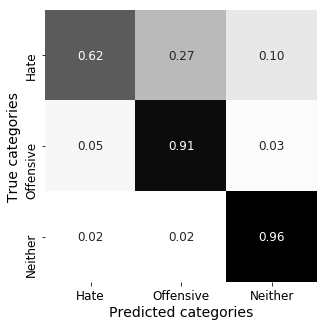

In [60]:
for _ in range(10):
    X_train, X_test, y_train, y_test = train_test_split(
        new_X, y, test_size=0.1
    )

    pipe = Pipeline([
        ('select', SelectFromModel(LogisticRegression(class_weight='balanced', penalty="l1", C=0.01))),
        ('model', LogisticRegression(class_weight='balanced', penalty='l2'))
    ])
    param_grid = [{}]
    grid = GridSearchCV(
        pipe, 
        param_grid,
        cv=StratifiedKFold(n_splits=5).split(X_train, y_train), 
        verbose=2, 
        n_jobs=N_JOBS
    )

    # treinando...
    model = grid.fit(X_train, y_train)
    y_preds = model.predict(X_test)

#     best_pipe = grid.best_estimator_
#     indices = best_pipe.named_steps['select'].get_support(indices=True)

#     report = classification_report(y_test, y_preds)
#     print(report)

    cm = confusion_matrix(y_test, y_preds)
    mp = np.zeros((3,3))
    for i in range(0,3):
        mp[i,:] = cm[i,:]/float(cm[i,:].sum())

    print(mp[0][0], mp[1][1], mp[2][2])

#     names=['Hate','Offensive','Neither']
#     confusion_df = pd.DataFrame(matrix_proportions, index=names, columns=names)
#     plt.figure(figsize=(5,5))
#     seaborn.heatmap(
#         confusion_df, annot=True, annot_kws={"size": 12}, 
#         cmap='gist_gray_r',cbar=False, square=True, fmt='.2f'
#     )
#     plt.ylabel('True categories', fontsize=14)
#     plt.xlabel('Predicted categories', fontsize=14)
#     plt.tick_params(labelsize=12)

In [61]:
best_features2 = [feat_names[i] for i in indices]
print('Total: ', len(indices))
print(best_features2)

Total:  170
['america', 'american', 'anoth', 'ass', 'ass cracker', 'ass nigga', 'bad', 'beaner', 'big', 'bird', 'bitch', 'black', 'border', 'born', 'bout', 'browni', 'busi', 'campu', 'charli', 'chill', 'chink', 'color', 'come', 'coon', 'countri', 'cracker', 'crazi', 'cunt', 'da', 'damn', 'die', 'doe', 'dyke', 'dyke bitch', 'fag', 'faggot', 'fat', 'femal', 'feminist', 'filth', 'first', 'fucc nicca', 'fuck', 'fuckin', 'gay', 'gettin', 'ghetto', 'girl', 'good', 'gook', 'got nigga', 'gotta', 'hard', 'hate', 'hi', 'ho', 'hoe', 'hood', 'hope', 'human', 'israel', 'jap', 'jew', 'jihadi', 'kill', 'lame', 'latina', 'let', 'like', 'look like', 'love', 'mexican', 'mock', 'money', 'monkey', 'much', 'muslim', 'muzzi', 'negro', 'nicca', 'nig', 'nigga', 'nigga bitch', 'nigga tri', 'niggah', 'niggaz', 'nigger', 'nigguh', 'niglet', 'oreo', 'peopl', 'play', 'pussi', 'pussi boy', 'queer', 'race', 'racist', 'real', 'redneck', 'retard', 'sex', 'shit', 'shoot', 'show', 'shut', 'side', 'smoke', 'sole', 'speak